<a href="https://colab.research.google.com/github/riccardogabellone/galaxy_recognition_project/blob/master/%5BFINAL_VERSION%5D_Galaxies_Classification_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import libraries**

In [0]:
import os
import logging
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
#import keras
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Add
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, GlobalMaxPooling2D, ZeroPadding2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, LearningRateScheduler
from tensorflow.keras.utils import plot_model

try:
  #tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
  tpu = "grpc://"+os.environ["COLAB_TPU_ADDR"]
  print(tf.__version__)
except KeyError: # If TPU not found
  tpu = None
  print(tf.__version__, tf.test.gpu_device_name())

# Select appropriate distribution strategy
if tpu:
  #tf.tpu.experimental.initialize_tpu_system(tpu)
  #strategy = tf.distribute.experimental.TPUStrategy(tpu, steps_per_run=128)
  print('Running on TPU ', tpu)
  ##from tensorflow.contrib.tpu.python.tpu import keras_support  
else:
  #strategy = tf.distribute.get_strategy() # Default strategy that works on CPU and single GPU
  print('Running on CPU instead')
#print("Number of accelerators: ", strategy.num_replicas_in_sync)

import pandas as pd
from google.colab import files

from PIL import Image
import os.path
import sys
import copy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

1.15.0 /device:GPU:0
Running on CPU instead


In [0]:
from google.colab import drive
drive.mount('/content/drive')

**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 37

BATCH_SIZE = 32     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results | original to 256

LR = 1e-3            # The initial Learning Rate was setted to 1e-3
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-4  

NUM_EPOCHS = 20      # initial set to 30
STEP_SIZE = 10        # initial set to 20
GAMMA = 0.1            # initial set to 0.1

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [0]:
train_datagen = ImageDataGenerator(
    fill_mode='nearest',
    cval=0,
    rescale=1. / 255,
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1)

test_datagen = ImageDataGenerator(rescale=1./255)


**Prepare Dataset**

In [0]:
#kaggle competitions download -c galaxy-zoo-the-galaxy-challenge
classes = [
    'Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2', 'Class3.1',
    'Class3.2', 'Class4.1', 'Class4.2', 'Class5.1', 'Class5.2', 'Class5.3',
    'Class5.4', 'Class6.1', 'Class6.2', 'Class7.1', 'Class7.2', 'Class7.3',
    'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5', 'Class8.6',
    'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1', 'Class10.2',
    'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3', 'Class11.4',
    'Class11.5', 'Class11.6'
]

if not os.path.isdir('./galaxy_recognition_project'):
  !git clone https://github.com/riccardogabellone/galaxy_recognition_project.git

DATA_DIR = 'galaxy_recognition_project'
decision_tree = pd.read_csv("galaxy_recognition_project/training_solutions_rev1/training_solutions_rev1.csv")

def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

train_path = 'galaxy_recognition_project/images_training_rev1'
test_path = 'galaxy_recognition_project/images_test_rev1'

def append_ext(fn):
    return fn + ".jpg"

decision_tree["id"] = decision_tree['GalaxyID'].astype(str).apply(append_ext)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=decision_tree,
    directory=train_path,
    x_col="id",
    y_col=classes,
    subset="training",
    batch_size=BATCH_SIZE,
    seed=123,
    shuffle=True,
    class_mode="other",
    target_size=(224, 224))

valid_generator = train_datagen.flow_from_dataframe(
    dataframe=decision_tree,
    directory=train_path,
    x_col="id",
    y_col=classes,
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=123,
    shuffle=True,
    class_mode="other",
    target_size=(224, 224))

testdf = pd.read_csv("galaxy_recognition_project/all_zeros_benchmark/all_zeros_benchmark.csv")
testdf["id"] = testdf['GalaxyID'].astype(str).apply(append_ext)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = testdf,
    directory=test_path,
    x_col = "id",
    y_col = None,
    classes = None,
    class_mode=None,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    target_size=(224, 224),
    seed=123,
    shuffle=False
    )

Cloning into 'galaxy_recognition_project'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 142020 (delta 1), reused 6 (delta 1), pack-reused 142011
Receiving objects: 100% (142020/142020), 4.19 GiB | 49.70 MiB/s, done.
Resolving deltas: 100% (210/210), done.
Checking out files: 100% (141681/141681), done.
Found 55421 validated image filenames.
Found 6157 validated image filenames.
Found 79975 validated image filenames.


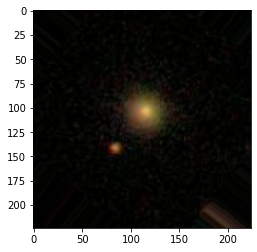

[0.602107   0.378332   0.019561   0.         0.378332   0.
 0.378332   0.         0.378332   0.         0.31476693 0.
 0.06356507 0.10594    0.89406    0.57465453 0.02745247 0.
 0.03350374 0.02673067 0.         0.         0.04570559 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]


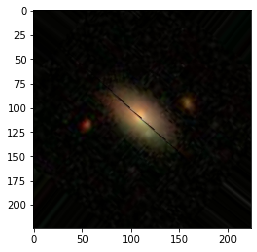

[0.646201   0.321552   0.032248   0.         0.321552   0.
 0.321552   0.         0.321552   0.         0.1441672  0.1773848
 0.         0.5767     0.4233     0.         0.58251401 0.06368699
 0.         0.         0.5086494  0.         0.0680506  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]


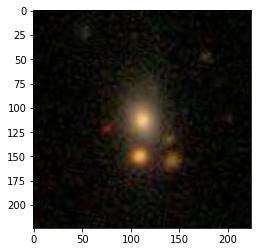

[0.02352941 0.02352941 0.01568628]


In [0]:
plt.imshow(train_generator[42][0][0])
plt.show()
print(train_generator[42][1][0])

plt.imshow(valid_generator[42][0][0])
plt.show()
print(valid_generator[42][1][0])

plt.imshow(test_generator[42][0])
plt.show()
print(test_generator[42][0][0][0])

**Prepare Network**

In [0]:
def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def CNN_galaxy(model):
  #with strategy.scope():
    inp = model    
    model = Sequential()
    model.add(inp)
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(GlobalMaxPooling2D())

    model.add(Flatten())
    #model.add(Dropout(0.25))
    #model.add(Dense(64))
    #model.add(Activation('relu'))
    
    model.add(Dropout(0.25))
    model.add(Dense(NUM_CLASSES))
    model.add(Activation('sigmoid'))

    for layer in model.layers:
      layer.trainable = True

    print("compiling the model...")
    optimizer = tf.keras.optimizers.Adam(lr=LR, decay=WEIGHT_DECAY)
    model.compile(optimizer, loss='mse', metrics=[root_mean_squared_error])

    return model

#net = CNN_galaxy()

img_shape = (224, 224, 3)
xception_model = tf.keras.applications.xception.Xception(include_top=False, input_shape=img_shape)
net = CNN_galaxy(xception_model)

#net.summary()
#plot_model(net, show_shapes=True, show_layer_names=False)

**Train**

In [0]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

def lr_scheduler(epoch):
    if epoch <= STEP_SIZE: return LR
    else: return LR*GAMMA

early_stopping = EarlyStopping(
    monitor='val_loss', patience=4, verbose=1, mode='auto')

history = LossHistory()

path_model = 'drive/My Drive/Colab Notebooks/checkpoint_galaxies.hdf5'
checkpointer = ModelCheckpoint(filepath=path_model, verbose=2, save_best_only=True)

scheduler = LearningRateScheduler(lr_scheduler, verbose=1)

STEP_TRAIN = train_generator.n // train_generator.batch_size
STEP_VALID = valid_generator.n // valid_generator.batch_size

hist = net.fit_generator(
    train_generator,
    steps_per_epoch= STEP_TRAIN,
    validation_data=valid_generator,
    validation_steps= STEP_VALID,
    epochs=NUM_EPOCHS,
    callbacks=[history, checkpointer, early_stopping, scheduler])
    #callbacks=[history, checkpointer, early_stopping])

plt.figure(figsize=(12, 8))
plt.plot(hist.epoch, hist.history['loss'], label='Training Loss')
plt.plot(hist.epoch, hist.history['val_loss'], label='Validation', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()


Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/5
 192/1731 [==>...........................] - ETA: 9:19 - loss: 0.0064 - root_mean_squared_error: 0.0797
Epoch 00001: val_loss improved from inf to 0.00640, saving model to drive/My Drive/Colab Notebooks/checkpoint_galaxies.hdf5
1731/1731 [==============================] - 771s 445ms/step - loss: 0.0064 - root_mean_squared_error: 0.0796 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0797

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/5
 192/1731 [==>...........................] - ETA: 9:23 - loss: 0.0063 - root_mean_squared_error: 0.0793
Epoch 00002: val_loss improved from 0.00640 to 0.00633, saving model to drive/My Drive/Colab Notebooks/checkpoint_galaxies.hdf5
1731/1731 [==============================] - 771s 445ms/step - loss: 0.0063 - root_mean_squared_error: 0.0794 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0793

Epoch 00003: LearningRateScheduler reducing lea

**Test**

In [0]:
net = load_model('drive/My Drive/Colab Notebooks/checkpoint_galaxies.hdf5', custom_objects={'root_mean_squared_error':root_mean_squared_error})
#net.summary()
test_generator.reset()

predictions = net.predict_generator(
    test_generator,
    steps=test_generator.n / test_generator.batch_size,
    verbose=1)

def get_id(fname):
    return fname.replace(".jpg", "").split("/")[0]

header = open('galaxy_recognition_project/all_zeros_benchmark/all_zeros_benchmark.csv', 'r').readlines()[0]

with open('Output.csv', 'w') as outfile:
    outfile.write(header)
    for i in range(len(test_generator.filenames)):
        id_ = (get_id(test_generator.filenames[i]))
        pred = predictions[i]
        outline = id_ + "," + ",".join([str(x) for x in pred])
        outfile.write(outline + "\n")
!cp Output.csv drive/My\ Drive/Colab\ Notebooks/predictions.csv       

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
2500/2499 [==============================] - 297s 119ms/step


**Label predictions**

In [0]:
preds = pd.read_csv("drive/My Drive/Colab Notebooks/predictions.csv")
preds["Label"] = preds['GalaxyID'].astype(str)

dict = { 'Class1.1':'smooth', 'Class1.2':'disc', 'Class1.3':'star or artefact', 'Class2.1':'yes', 'Class2.2':'no', 'Class3.1':'yes',
    'Class3.2':'no', 'Class4.1':'spiral', 'Class4.2':'no', 'Class5.1':'no bulge', 'Class5.2':'little bulge', 'Class5.3':'obvious bulge',
    'Class5.4':'dominant bulge', 'Class6.1':'yes', 'Class6.2':'no', 'Class7.1':'completely round', 'Class7.2':'in between', 'Class7.3':'cigar-shaped',
    'Class8.1':'ring', 'Class8.2':'lens or arc', 'Class8.3':'disturbed', 'Class8.4':'irregular', 'Class8.5':'odd feature', 'Class8.6':'merger',
    'Class8.7':'dust lane', 'Class9.1':'rounded bulge', 'Class9.2':'boxy bulge', 'Class9.3':'no bulge', 'Class10.1':'tight arms', 'Class10.2':'medium arms',
    'Class10.3':'loose arms', 'Class11.1':'1 arm', 'Class11.2':'2 arms', 'Class11.3':'3 arms', 'Class11.4':'4 arms', 'Class11.5':'more than 4 arms', 'Class11.6':'cannot count arms'}

links = { '1.1':'7.', '7.':'6.', '6.1':'8.', '1.2':'2.', '2.1':'9.', '9.':'6.', '2.2':'3.', '3.':'4.', '4.1':'10.', '10.':'11.', '11.':'5.', '5.':'6.','4.2':'5.' }

for i in tqdm(range(len(preds)), total=len(preds)):
  cur = ''
  stop = 1
  class_type = '1.'
  pred = preds[i:i+1]
  while stop:
    v = []
    for c in classes:
      if class_type in c:
        v.append(pred[c][i])
    if class_type is '1.' and len(v) > 3:
       v = v[:3]
    index = v.index(max(v))
    full_type = class_type+str(index+1)
    name = 'Class'+full_type
    if dict[name] is not 'yes' and dict[name] is not 'no': 
      cur += dict[name]+', '
    if full_type in links: 
      class_type = links[full_type]
    elif class_type in links: 
      class_type = links[class_type]
    else: stop = 0
  preds["Label"][i] = cur[:len(cur)-2]

print(preds)

  0%|          | 0/79975 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 79975/79975 [02:11<00:00, 608.55it/s]


       GalaxyID  Class1.1  ...  Class11.6                      Label
0        100018  0.444073  ...   0.090924         Disc, little bulge
1        100037  0.512562  ...   0.020222       Smooth, cigar shaped
2        100042  0.671261  ...   0.011073       Smooth, cigar shaped
3        100052  0.624572  ...   0.036695   Smooth, completely round
4        100056  0.407231  ...   0.004006             Disc, no bulge
...         ...       ...  ...        ...                        ...
79970    999955  0.872973  ...   0.000636   Smooth, completely round
79971    999981  0.039215  ...   0.000074        Disc, rounded bulge
79972    999990  0.165712  ...   0.049064  Disc, no bulge, irregular
79973    999994  0.407264  ...   0.092388         Disc, little bulge
79974    999996  0.730560  ...   0.008658       Smooth, almost round

[79975 rows x 39 columns]


**Test and label our images**

Found 16 validated image filenames.


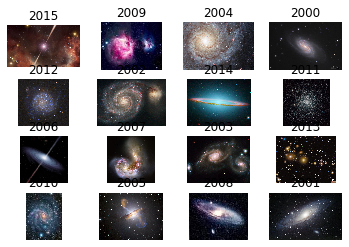

16/16 [==============================] - 2s 125ms/step


  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 16/16 [00:00<00:00, 462.63it/s]


    GalaxyID  ...                                              Label
0       2000  ...  disc, spiral, tight arms, more than 4 arms, li...
1       2001  ...  disc, spiral, tight arms, cannot count arms, l...
2       2002  ...  disc, spiral, tight arms, more than 4 arms, li...
3       2003  ...  disc, spiral, tight arms, 2 arms, little bulge...
4       2004  ...  disc, spiral, tight arms, more than 4 arms, li...
5       2005  ...  disc, spiral, tight arms, cannot count arms, l...
6       2006  ...     disc, spiral, tight arms, 2 arms, little bulge
7       2007  ...  disc, spiral, tight arms, cannot count arms, l...
8       2008  ...  disc, spiral, tight arms, cannot count arms, l...
9       2009  ...                        disc, no bulge, odd feature
10      2010  ...  disc, spiral, tight arms, more than 4 arms, ob...
11      2011  ...     disc, spiral, tight arms, 2 arms, little bulge
12      2012  ...  disc, spiral, tight arms, more than 4 arms, li...
13      2013  ...                 

In [0]:
img_path = 'galaxy_recognition_project/images_test_little'
df = pd.read_csv("galaxy_recognition_project/images_test_little_zeros/test_zeros_benchmark.csv")
df["id"] = df['GalaxyID'].astype(str).apply(append_ext)

img_generator = test_datagen.flow_from_dataframe(
    dataframe = df,
    directory= img_path,
    x_col = "id",
    y_col = None,
    classes = None,
    class_mode = None,
    color_mode = "rgb",
    batch_size = 1,
    target_size = (224, 224),
    seed = 123,
    shuffle = False
    )

galaxies = os.listdir(img_path)
for num, x in enumerate(galaxies):
    img = Image.open(img_path + '/' + x)
    plt.subplot(4,4,num+1)
    plt.title(x.split('.')[0])
    plt.axis('off')
    plt.imshow(img)
plt.show()

net = load_model('drive/My Drive/Colab Notebooks/checkpoint_galaxies.hdf5', custom_objects={'root_mean_squared_error':root_mean_squared_error})
#net = load_model('galaxy_recognition_project/checkpoints/net_3-conv_1-dense_1e-4LR/checkpoint_galaxies.hdf5', custom_objects={'root_mean_squared_error':root_mean_squared_error})
#net.summary()
img_generator.reset()

predictions = net.predict_generator(
    img_generator,
    steps=img_generator.n / img_generator.batch_size,
    verbose=1)

#print(predictions)

def get_id(fname):
    return fname.replace(".jpg", "").split("/")[0]

header = open('galaxy_recognition_project/images_test_little_zeros/test_zeros_benchmark.csv', 'r').readlines()[0]

with open('Output_little.csv', 'w') as outfile:
    outfile.write(header)
    for i in range(len(img_generator.filenames)):
        id_ = (get_id(img_generator.filenames[i]))
        pred = predictions[i]
        outline = id_ + "," + ",".join([str(x) for x in pred])
        outfile.write(outline + "\n")
!cp Output_little.csv drive/My\ Drive/Colab\ Notebooks/predictions_little.csv  

preds = pd.read_csv("drive/My Drive/Colab Notebooks/predictions_little.csv")
preds["Label"] = preds['GalaxyID'].astype(str)

for i in tqdm(range(len(preds)), total=len(preds)):
  cur = ''
  stop = 1
  class_type = '1.'
  pred = preds[i:i+1]
  while stop:
    v = []
    for c in classes:
      if class_type in c:
        v.append(pred[c][i])
    if class_type is '1.' and len(v) > 3:
       v = v[:3]
    index = v.index(max(v))
    full_type = class_type+str(index+1)
    name = 'Class'+full_type
    if dict[name] is not 'yes' and dict[name] is not 'no': 
      cur += dict[name]+', '
    if full_type in links: 
      class_type = links[full_type]
    elif class_type in links: 
      class_type = links[class_type]
    else: stop = 0
  preds["Label"][i] = cur[:len(cur)-2]

print(preds)

with open('Output_little.csv', 'w') as outfile:
    outfile.write(header)
    for i in range(len(img_generator.filenames)):
        id_ = (get_id(img_generator.filenames[i]))
        pred = []
        for c in classes:
          pred += [preds[c][i]]
        outline = id_ + "," + ",".join([str(x) for x in pred]) + "," + preds["Label"][i]
        outfile.write(outline + "\n")
!cp Output_little.csv drive/My\ Drive/Colab\ Notebooks/predictions_little_labeled.csv 